### Conversion of a CT image to a noisy sinogram and reconstruction with noise and without noise.  

This notebook is a tutorial on reconstruction of high-dynamic range CT images with proper physical scaling and a realistic noise model. 

**Outline of processing:**

1. Read image: in Hounsfield units (air=0, water=1000)
- Scale so that air=0, water=1
- Take the raw sinogram using a specified number of views
- Scale to account for pixel pitch and x-ray density
- Add noise to the sinogram using the correct variance
- Reconstruct from the original and noisy sinogram
- Display the reconstructions and sinograms


In [1]:
''' 
Authors:  Gregery T. Buzzard and Charles A. Bouman
Copyright 2019, Gregery T. Buzzard and Charles A. Bouman

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software 
without restriction, including without limitation the rights to use, copy, modify, merge, 
publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons 
to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING 
BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. 
IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
'''
import imageio
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, resize, iradon,iradon_sart

**Input images:** 

The images are assumed to be single-energy (~100 KeV) CT images and have high dynamic range.  The pixel values are  in Hounsfield units, with air as 0 and water as 1000.  Hounsfield units are closely related to the atomic weight of the associated material. We then scale so that water is 1 and air is 0. In these scaled units, steel and other dense metals are about 12 to 15, but may go up to 20.   

The file make_data.py creates high dynamic range images with some characteristics like those seen in CT scans of baggage.  


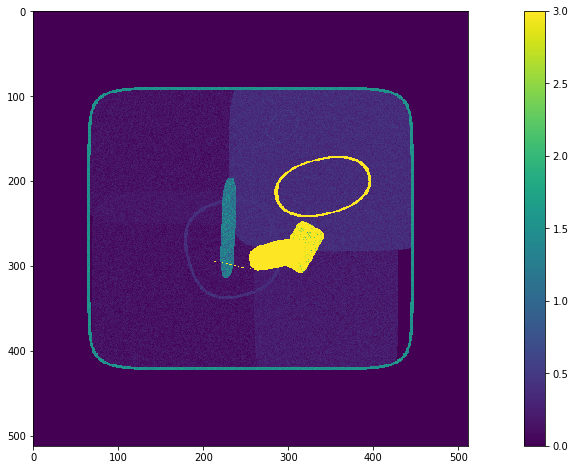

In [2]:
# Image to use
filename = 'images/image01.png' 

# Read the image and resize if desired.  
# Leave imsize = [] to use the natural image size

imsize = []
orig_img=imageio.imread(filename).astype(np.float)

# The image is in Hounsfield units
# Convert to Hounsfield units/1000 
img = orig_img/1000.

plt.figure(figsize=(20, 8))
plt.imshow(img,vmin=0,vmax=3);plt.colorbar();plt.show()


**Scaling:**  

All CT scans are relative to a baseline scan with no objects - i.e., a scan of air, which makes air 0. 

The raw projection operator (radon function in python or matlab) sums along pixels, with assumed 
distance 1 between pixels.  To get the correct units, we need to scale.  The first step is raw projection:

$$\text{Raw projection} = Ax$$ 

($x$ is the image as scaled above, $Ax$ is the output of the radon method)

This result needs to be scaled according to physical units.  

**We scale by the pixel pitch (distance between pixels) times the x-ray density of water.**
    
We assume pixel pitch of 0.93 mm = 0.093 cm and water density at 100KeV of 0.17 cm^{-1}.  With an image size of 512x512 pixels, this corresponds to a width of 512*0.93/10 = 47.16 cm or 18.75 in.  Scaling of the projection is then 

$$ y \text{ (or scaled projection) } = Ax * \text{pixel_pitch} * \text{water_xray_density} $$

Note that if the original image was resized, then we have to adjust the pixel pitch accordingly so that the image has the same physical dimensions.  For example, if the image was resized from 512x512 to 256x256, then the pixel pitch is increased by a factor of two.  

The sinogram values should be on the order of 0-5 for most images.  Here are approximate X-ray densities for common materials you might have in an image 

- water ~0.17 $\text{cm}^{-1}$
- steel ~3.0 $\text{cm}^{-1}$
- aluminum ~1.0 $\text{cm}^{-1}$
- plastic ~0.1 $\text{cm}^{-1}$


In [3]:
cur_size = min(img.shape)
image_scale = 1
# Set the sinogram scaling factor
pixel_pitch = 0.093 # in cm
water_xray_density = 0.17 # in cm^{-1}

pixel_pitch = pixel_pitch / image_scale

sino_scale = pixel_pitch * water_xray_density



**Forward projection:**

Next we take the sinogram, scaled as above. 

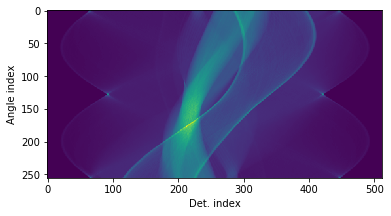

In [4]:
# Number of views
views=256
lambda0=1600000

# Set up the views and take the radon transform
theta = np.linspace(0., 180., views, endpoint=False)

# Set up the views and take the radon transform
theta = np.linspace(0., 180., views, endpoint=False)

sinogram = radon(img, theta=theta, circle=True)
sinogram *= sino_scale

# Sinogram noise variance scaling
alpha = 1/lambda0

# Add noise to the sinogram
w = np.sqrt(alpha*np.exp(sinogram)) * np.random.randn(cur_size,views)

nsinogram = sinogram + w

plt.imshow(nsinogram.T);plt.xlabel('Det. index');plt.ylabel('Angle index')
plt.show()

**Reconstruction:**

Next we invert the radon transform using filtered backprojection for both the noise-free and noisy sinograms.

Since the sinogram was scaled using sino_scale as described above, we need to apply the inverse scaling to the reconstructions.  

In [5]:
# Invert the radon transform in the noisy cases using FBP and SART algorithms 

nrecon_fbp = iradon(nsinogram, theta=theta, circle=True,filter='ramp')

max_iter = 5
nrecon_sart = np.zeros_like(nrecon_fbp)
for iter in range(max_iter):
    nrecon_sart =iradon_sart(nsinogram,theta=theta,image=nrecon_sart)

# Scale to recover the appropriate units
nrecon_fbp = nrecon_fbp / sino_scale
nrecon_sart = nrecon_sart / sino_scale

**Display**

We display the original and reconstructed images and the sinograms.  

Note that these images have a scale bar to indicate the intensity and that all the images are scaled to have the same intensity range.  We show several intensity bands to highlight the high dynamic range.  The reconstructions have values outside the given range, so the intensities are clipped, but the full range is shown in the titles.  

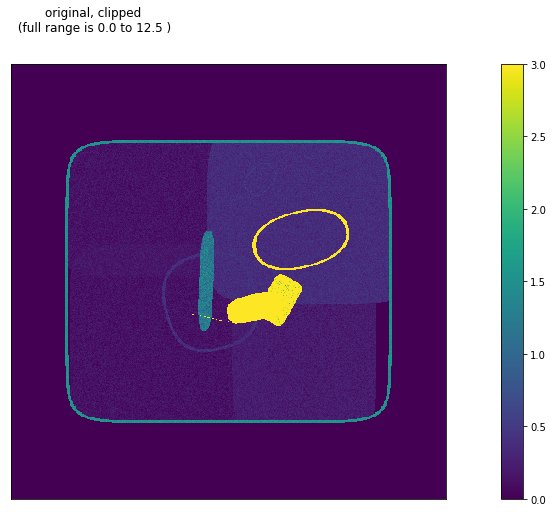

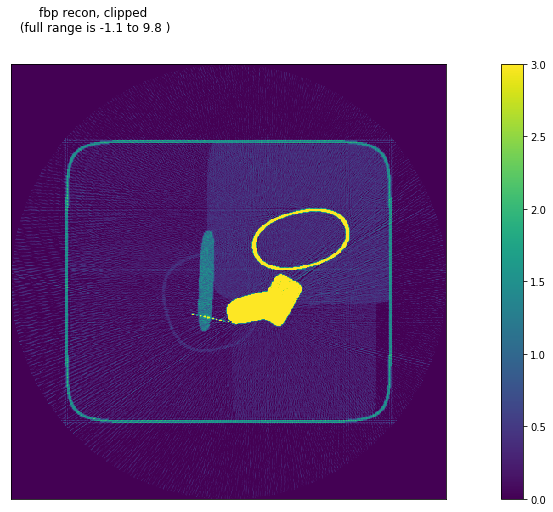

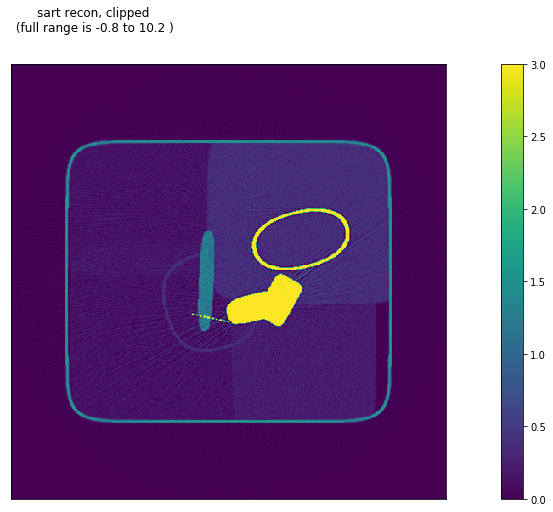

In [6]:
win_min = 0
win_max = 2

bounds = []
for im in [img, nrecon_fbp, nrecon_sart]:
    cur_min = np.round(np.amin(im),1)
    cur_max = np.round(np.amax(im),1)
    bounds.append('{} to {}'.format(str(cur_min), str(cur_max)))
# Display the original and reconstructed images
titles = ['original, clipped\n (full range is ' + bounds[0] + ' )']
titles.append('fbp recon, clipped\n (full range is ' + bounds[1] + ' )')
titles.append('sart recon, clipped\n (full range is ' + bounds[2] + ' )')
     

vmin = [0]
vmax = [3]
          
num_scales = len(vmin)

for i, im in enumerate([img, nrecon_fbp, nrecon_sart]):
    plt.figure(i, figsize=(20, 8))
    plt.clf()        
    
    for k in range(num_scales):
        # display at various scales
        ax = plt.subplot(1,num_scales, k + 1)
        plt.imshow(im, vmin=vmin[k], vmax=vmax[k])
        plt.colorbar()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)   

    plt.suptitle(titles[i])
    #plt.tight_layout()
    plt.show()

